In [ ]:
!tf_upgrade_v2 \
  --infile DL_NG_ConvNetApplication.ipynb \
  --outfile DL_NG_ConvNetApplication_v2.ipynb\


Notes: This assignment was contructed in 2017 so the libraries used are older modules that are missing some key attributes. We have upgraded the tensorflow script to 2.1 version and we still have errors. .contrib for fully connected layers in forward prop 

# Convolutional Neural Networks: Application
Welcome to Course 4's second assignment! In this notebook, you will:

Implement helper functions that you will use when implementing a TensorFlow model
Implement a fully functioning ConvNet using TensorFlow
After this assignment you will be able to:

Build and train a ConvNet in TensorFlow for a classification problem
We assume here that you are already familiar with TensorFlow. If you are not, please refer the TensorFlow Tutorial of the third week of Course 2 ("Improving deep neural networks").

# TensorFlow model
In the previous assignment, you built helper functions using numpy to understand the mechanics behind convolutional neural networks. Most practical applications of deep learning today are built using programming frameworks, which have many built-in functions you can simply call.

As usual, we will start by loading in the packages.

In [1]:
import math
import numpy as np
import h5py
import matplotlib.pyplot as plt
import scipy
from PIL import Image
from scipy import ndimage
import tensorflow as tf
from tensorflow.python.framework import ops

%matplotlib inline
np.random.seed(1)

In [2]:
def load_dataset():
    train_dataset = h5py.File('train_signs.h5', "r")
    train_set_x_orig = np.array(train_dataset["train_set_x"][:]) # your train set features
    train_set_y_orig = np.array(train_dataset["train_set_y"][:]) # your train set labels

    test_dataset = h5py.File('test_signs.h5', "r")
    test_set_x_orig = np.array(test_dataset["test_set_x"][:]) # your test set features
    test_set_y_orig = np.array(test_dataset["test_set_y"][:]) # your test set labels

    classes = np.array(test_dataset["list_classes"][:]) # the list of classes

    train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
    test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))

    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes


In [3]:
X_train_orig, Y_train_orig, X_test_orig, Y_test_orig, classes = load_dataset()

y = 0


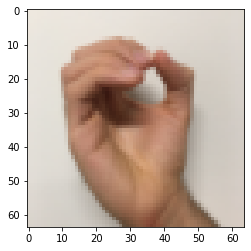

In [4]:
# Example of a picture
index = 1
plt.imshow(X_train_orig[index])
print ("y = " + str(np.squeeze(Y_train_orig[:, index])))

In [5]:
def convert_to_one_hot(Y, C):
    Y = np.eye(C)[Y.reshape(-1)].T
    return Y

In [6]:
X_train = X_train_orig/255.
X_test = X_test_orig/255.
Y_train = convert_to_one_hot(Y_train_orig, 6).T
Y_test = convert_to_one_hot(Y_test_orig, 6).T
print ("number of training examples = " + str(X_train.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(Y_train.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(Y_test.shape))
conv_layers = {}

number of training examples = 1080
number of test examples = 120
X_train shape: (1080, 64, 64, 3)
Y_train shape: (1080, 6)
X_test shape: (120, 64, 64, 3)
Y_test shape: (120, 6)


# Create placeholders
TensorFlow requires that you create placeholders for the input data that will be fed into the model when running the session.

Exercise: Implement the function below to create placeholders for the input image X and the output Y. You should not define the number of training examples for the moment. To do so, you could use "None" as the batch size, it will give you the flexibility to choose it later. Hence X should be of dimension [None, n_H0, n_W0, n_C0] and Y should be of dimension [None, n_y]. Hint.

In [7]:
# GRADED FUNCTION: create_placeholders

def create_placeholders(n_H0, n_W0, n_C0, n_y):
    """
    Creates the placeholders for the tensorflow session.

    Arguments:
    n_H0 -- scalar, height of an input image
    n_W0 -- scalar, width of an input image
    n_C0 -- scalar, number of channels of the input
    n_y -- scalar, number of classes

    Returns:
    X -- placeholder for the data input, of shape [None, n_H0, n_W0, n_C0] and dtype "float"
    Y -- placeholder for the input labels, of shape [None, n_y] and dtype "float"
    """

    ### START CODE HERE ### (≈2 lines)
    X = tf.compat.v1.placeholder(tf.float32, shape=[None, n_H0, n_W0, n_C0])
    Y = tf.compat.v1.placeholder(tf.float32, shape=[None, n_y])
    ### END CODE HERE ###

    return X, Y

In [8]:
tf.compat.v1.disable_eager_execution()

In [9]:
X, Y = create_placeholders(64, 64, 3, 6)
print ("X = " + str(X))
print ("Y = " + str(Y))

X = Tensor("Placeholder:0", shape=(None, 64, 64, 3), dtype=float32)
Y = Tensor("Placeholder_1:0", shape=(None, 6), dtype=float32)


# Initialize parameters
You will initialize weights/filters $W1$ and $W2$ using tf.contrib.layers.xavier_initializer(seed = 0). You don't need to worry about bias variables as you will soon see that TensorFlow functions take care of the bias. Note also that you will only initialize the weights/filters for the conv2d functions. TensorFlow initializes the layers for the fully connected part automatically. We will talk more about that later in this assignment.

Exercise: Implement initialize_parameters(). The dimensions for each group of filters are provided below. Reminder - to initialize a parameter $W$ of shape [1,2,3,4] in Tensorflow, use:

W = tf.get_variable("W", [1,2,3,4], initializer = ...)

In [10]:
# GRADED FUNCTION: initialize_parameters

def initialize_parameters():
    """
    Initializes weight parameters to build a neural network with tensorflow. The shapes are:
                        W1 : [4, 4, 3, 8]
                        W2 : [2, 2, 8, 16]
    Returns:
    parameters -- a dictionary of tensors containing W1, W2
    """

    tf.compat.v1.set_random_seed(1)                              # so that your "random" numbers match ours

    ### START CODE HERE ### (approx. 2 lines of code)
    W1 = tf.compat.v1.get_variable('W1',[4, 4, 3, 8], initializer = tf.compat.v1.keras.initializers.VarianceScaling(scale=1.0, mode="fan_avg", distribution="uniform", seed = 0))
    W2 = tf.compat.v1.get_variable('W2',[2, 2, 8, 16], initializer = tf.compat.v1.keras.initializers.VarianceScaling(scale=1.0, mode="fan_avg", distribution="uniform", seed = 0))
    ### END CODE HERE ###

    parameters = {"W1": W1,
                  "W2": W2}

    return parameters

In [11]:
tf.compat.v1.reset_default_graph()
with tf.compat.v1.Session() as sess_test:
    parameters = initialize_parameters()
    init = tf.compat.v1.global_variables_initializer()
    sess_test.run(init)
    print("W1 = " + str(parameters["W1"].eval()[1,1,1]))
    print("W2 = " + str(parameters["W2"].eval()[1,1,1]))

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
W1 = [ 0.00131723  0.1417614  -0.04434952  0.09197326  0.14984085 -0.03514394
 -0.06847463  0.05245192]
W2 = [-0.08566415  0.17750949  0.11974221  0.16773748 -0.0830943  -0.08058
 -0.00577033 -0.14643836  0.24162132 -0.05857408 -0.19055021  0.1345228
 -0.22779644 -0.1601823  -0.16117483 -0.10286498]


# Forward propagation
In TensorFlow, there are built-in functions that carry out the convolution steps for you.

tf.nn.conv2d(X,W1, strides = [1,s,s,1], padding = 'SAME'): given an input $X$ and a group of filters $W1$, this function convolves $W1$'s filters on X. The third input ([1,f,f,1]) represents the strides for each dimension of the input (m, n_H_prev, n_W_prev, n_C_prev). You can read the full documentation here

tf.nn.max_pool(A, ksize = [1,f,f,1], strides = [1,s,s,1], padding = 'SAME'): given an input A, this function uses a window of size (f, f) and strides of size (s, s) to carry out max pooling over each window. You can read the full documentation here

tf.nn.relu(Z1): computes the elementwise ReLU of Z1 (which can be any shape). You can read the full documentation here.

tf.contrib.layers.flatten(P): given an input P, this function flattens each example into a 1D vector it while maintaining the batch-size. It returns a flattened tensor with shape [batch_size, k]. You can read the full documentation here.

tf.contrib.layers.fully_connected(F, num_outputs): given a the flattened input F, it returns the output computed using a fully connected layer. You can read the full documentation here.

In the last function above (tf.contrib.layers.fully_connected), the fully connected layer automatically initializes weights in the graph and keeps on training them as you train the model. Hence, you did not need to initialize those weights when initializing the parameters.

Exercise:

Implement the forward_propagation function below to build the following model: CONV2D -> RELU -> MAXPOOL -> CONV2D -> RELU -> MAXPOOL -> FLATTEN -> FULLYCONNECTED. You should use the functions above.

In detail, we will use the following parameters for all the steps:

 - Conv2D: stride 1, padding is "SAME"
 - ReLU
 - Max pool: Use an 8 by 8 filter size and an 8 by 8 stride, padding is "SAME"
 - Conv2D: stride 1, padding is "SAME"
 - ReLU
 - Max pool: Use a 4 by 4 filter size and a 4 by 4 stride, padding is "SAME"
 - Flatten the previous output.
 - FULLYCONNECTED (FC) layer: Apply a fully connected layer without an non-linear activation function. Do not call the softmax here. This will result in 6 neurons in the output layer, which then get passed later to a softmax. In TensorFlow, the softmax and cost function are lumped together into a single function, which you'll call in a different function when computing the cost. 

In [12]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D

In [13]:
def forward_propagation(X, parameters):
    
    W1 = parameters['W1']
    W2 = parameters['W2']

    model = Sequential([
        Conv2d(input=X,filters=W1, strides = [1,1,1,1], padding = 'SAME', activation='relu'),
        MaxPooling2d(64, 64, 3, ksize = [1,8,8,1], strides = [1,8,8,1], padding = 'SAME'),
        Conv2d(64, 64, 3,filters=W2, strides = [1,1,1,1], padding = 'SAME', activation='relu'),
        MaxPooling2d(64, 64, 3, ksize = [1,4,4,1], strides = [1,4,4,1], padding = 'SAME'),
        Flatten(),
        Dense(512, activation= None ),
        Dense(6)
])
    
    return Z3
        

In [14]:
model.summary

NameError: name 'model' is not defined

In [37]:
# GRADED FUNCTION: forward_propagation

def forward_propagation(X, parameters):
    """
    Implements the forward propagation for the model:
    CONV2D -> RELU -> MAXPOOL -> CONV2D -> RELU -> MAXPOOL -> FLATTEN -> FULLYCONNECTED

    Arguments:
    X -- input dataset placeholder, of shape (input size, number of examples)
    parameters -- python dictionary containing your parameters "W1", "W2"
                  the shapes are given in initialize_parameters

    Returns:
    Z3 -- the output of the last LINEAR unit
    """

    # Retrieve the parameters from the dictionary "parameters"
    W1 = parameters['W1']
    W2 = parameters['W2']

    ### START CODE HERE ###
    # CONV2D: stride of 1, padding 'SAME'
    Z1 = Conv2d(input=X,filters=W1, strides = [1,1,1,1], padding = 'SAME', activation='relu'),
    # RELU
    #A1 = tf.nn.relu(Z1)
    # MAXPOOL: window 8x8, sride 8, padding 'SAME'
    P1 = MaxPooling2d(input=Z1, ksize = [1,8,8,1], strides = [1,8,8,1], padding = 'SAME'),
    # CONV2D: filters W2, stride 1, padding 'SAME'
    Z2 = Conv2d(input=P1,filters=W2, strides = [1,1,1,1], padding = 'SAME', activation='relu'),
    # RELU
    #A2 = tf.nn.relu(Z2)
    # MAXPOOL: window 4x4, stride 4, padding 'SAME'
    P2 = MaxPooling2d(input=Z2, ksize = [1,4,4,1], strides = [1,4,4,1], padding = 'SAME'),
    # FLATTEN
       P2_shape = P2.get_shape().as_list()
    P2 = tf.reshape(P2, [tf.shape(P2)[0], -1]) 
    # FULLY-CONNECTED without non-linear activation function (not not call softmax).
    # 6 neurons in output layer. Hint: one of the arguments should be "activation_fn=None"
    Z3 = tf.nn.layers(input = P2, units = 6, activation = None)]

        
 



    ### END CODE HERE ###

    return Z3



SyntaxError: invalid syntax (<ipython-input-37-f7bcc07df292>, line 24)

In [20]:
tf.compat.v1.reset_default_graph()

with tf.compat.v1.Session() as sess:
    np.random.seed(1)
    X, Y = create_placeholders(64, 64, 3, 6)
    parameters = initialize_parameters()
    Z3 = forward_propagation(X, parameters)
    init = tf.compat.v1.global_variables_initializer()
    sess.run(init)
    a = sess.run(Z3, {X: np.random.randn(2,64,64,3), Y: np.random.randn(2,6)})
    print("Z3 = " + str(a))

NameError: name 'Conv2d' is not defined


Expected Output:

Z3 =	[[-0.44670227 -1.57208765 -1.53049231 -2.31013036 -1.29104376 0.46852064]
[-0.17601591 -1.57972014 -1.4737016 -2.61672091 -1.00810647 0.5747785 ]]


# Compute cost
Implement the compute cost function below. You might find these two functions helpful:

- tf.nn.softmax_cross_entropy_with_logits(logits = Z3, labels = Y): computes the softmax entropy loss. This function both computes the softmax activation function as well as the resulting loss. 
- tf.reduce_mean: computes the mean of elements across dimensions of a tensor. Use this to sum the losses over all the examples to get the overall cost. You can check the full documentation here.
#### Exercise: Compute the cost below using the function above.

In [15]:
# GRADED FUNCTION: compute_cost

def compute_cost(Y):
    """
    Computes the cost

    Arguments:
    Z3 -- output of forward propagation (output of the last LINEAR unit), of shape (6, number of examples)
    Y -- "true" labels vector placeholder, same shape as Z3

    Returns:
    cost - Tensor of the cost function
    """

    ### START CODE HERE ### (1 line of code)
    cost = tf.nn.softmax_cross_entropy_with_logits(logits = Y, labels = tf.stop_gradient( Y))
    cost = tf.reduce_mean(input_tensor=cost)
    ### END CODE HERE ###

    return cost

In [16]:
tf.compat.v1.reset_default_graph()

with tf.compat.v1.Session() as sess:
    np.random.seed(1)
    X, Y = create_placeholders(64, 64, 3, 6)
    parameters = initialize_parameters()
    cost = compute_cost(Y)
    init = tf.compat.v1.global_variables_initializer()
    sess.run(init)
    a = sess.run(cost, {X: np.random.randn(4,64,64,3), Y: np.random.randn(4,6)})
    print("cost = " + str(a))

cost = -4.0587807


##### Expected Output: cost =	2.91034

# Model
Finally you will merge the helper functions you implemented above to build a model. You will train it on the SIGNS dataset.

You have implemented random_mini_batches() in the Optimization programming assignment of course 2. Remember that this function returns a list of mini-batches.

Exercise: Complete the function below.

The model below should:

create placeholders
initialize parameters
forward propagate
compute the cost
create an optimizer
Finally you will create a session and run a for loop for num_epochs, get the mini-batches, and then for each mini-batch you will optimize the function. Hint for initializing the variables

In [22]:
# GRADED FUNCTION: model

def model(X_train, Y_train, X_test, Y_test, learning_rate = 0.009,
          num_epochs = 100, minibatch_size = 64, print_cost = True):
    """
    Implements a three-layer ConvNet in Tensorflow:
    CONV2D -> RELU -> MAXPOOL -> CONV2D -> RELU -> MAXPOOL -> FLATTEN -> FULLYCONNECTED

    Arguments:
    X_train -- training set, of shape (None, 64, 64, 3)
    Y_train -- test set, of shape (None, n_y = 6)
    X_test -- training set, of shape (None, 64, 64, 3)
    Y_test -- test set, of shape (None, n_y = 6)
    learning_rate -- learning rate of the optimization
    num_epochs -- number of epochs of the optimization loop
    minibatch_size -- size of a minibatch
    print_cost -- True to print the cost every 100 epochs

    Returns:
    train_accuracy -- real number, accuracy on the train set (X_train)
    test_accuracy -- real number, testing accuracy on the test set (X_test)
    parameters -- parameters learnt by the model. They can then be used to predict.
    """

    ops.reset_default_graph()                         # to be able to rerun the model without overwriting tf variables
    tf.compat.v1.set_random_seed(1)                             # to keep results consistent (tensorflow seed)
    seed = 3                                          # to keep results consistent (numpy seed)
    (m, n_H0, n_W0, n_C0) = X_train.shape
    n_y = Y_train.shape[1]
    costs = []                                        # To keep track of the cost

    # Create Placeholders of the correct shape
    ### START CODE HERE ### (1 line)
    X, Y = create_placeholders(n_H0, n_W0, n_C0, n_y)
    ### END CODE HERE ###

    # Initialize parameters
    ### START CODE HERE ### (1 line)
    parameters = initialize_parameters()
    ### END CODE HERE ###

    # Forward propagation: Build the forward propagation in the tensorflow graph
    ### START CODE HERE ### (1 line)
    Z3 = forward_propagation(X, parameters)
    ### END CODE HERE ###

    # Cost function: Add cost function to tensorflow graph
    ### START CODE HERE ### (1 line)
    cost = compute_cost(Z3, Y)
    ### END CODE HERE ###

    # Backpropagation: Define the tensorflow optimizer. Use an AdamOptimizer that minimizes the cost.
    ### START CODE HERE ### (1 line)
    optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)
    ### END CODE HERE ###

    # Initialize all the variables globally
    init = tf.compat.v1.global_variables_initializer()

    # Start the session to compute the tensorflow graph
    with tf.compat.v1.Session() as sess:

        # Run the initialization
        sess.run(init)

        # Do the training loop
        for epoch in range(num_epochs):

            minibatch_cost = 0.
            num_minibatches = int(m / minibatch_size) # number of minibatches of size minibatch_size in the train set
            seed = seed + 1
            minibatches = random_mini_batches(X_train, Y_train, minibatch_size, seed)

            for minibatch in minibatches:

                # Select a minibatch
                (minibatch_X, minibatch_Y) = minibatch
                # IMPORTANT: The line that runs the graph on a minibatch.
                # Run the session to execute the optimizer and the cost, the feedict should contain a minibatch for (X,Y).
                ### START CODE HERE ### (1 line)
                _ , temp_cost = sess.run([optimizer, cost], feed_dict={X: minibatch_X, Y: minibatch_Y})
                ### END CODE HERE ###

                minibatch_cost += temp_cost / num_minibatches


            # Print the cost every epoch
            if print_cost == True and epoch % 5 == 0:
                print ("Cost after epoch %i: %f" % (epoch, minibatch_cost))
            if print_cost == True and epoch % 1 == 0:
                costs.append(minibatch_cost)


        # plot the cost
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('iterations (per tens)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()

        # Calculate the correct predictions
        predict_op = tf.argmax(input=Z3, axis=1)
        correct_prediction = tf.equal(predict_op, tf.argmax(input=Y, axis=1))

        # Calculate accuracy on the test set
        accuracy = tf.reduce_mean(input_tensor=tf.cast(correct_prediction, "float"))
        print(accuracy)
        train_accuracy = accuracy.eval({X: X_train, Y: Y_train})
        test_accuracy = accuracy.eval({X: X_test, Y: Y_test})
        print("Train Accuracy:", train_accuracy)
        print("Test Accuracy:", test_accuracy)

        return train_accuracy, test_accuracy, parameters

In [23]:
_, _, parameters = model(X_train, Y_train, X_test, Y_test)

NameError: name 'Conv2d' is not defined

# Expected output: although it may not match perfectly, your expected output should be close to ours and your cost value should decrease.

-  **Cost after epoch 0 =**	1.917929
- **Cost after epoch 5 =**	1.506757
- **Train Accuracy =**	0.940741
- **Test Accuracy =**	0.783333
Congratulations! You have finised the assignment and built a model that recognizes SIGN language with almost 80% accuracy on the test set. If you wish, feel free to play around with this dataset further. You can actually improve its accuracy by spending more time tuning the hyperparameters, or using regularization (as this model clearly has a high variance).

Once again, here's a thumbs up for your work!

In [ ]:
from IPython.display import Image
Image("thumbs_up.jpeg")

In [ ]:
pip install scipy==1.1.0

In [ ]:
fname = "thumbs_up.jpeg"
image = np.array(ndimage.imread(fname, flatten=False))
my_image = scipy.misc.imresize(image, size=(64,64))
plt.imshow(my_image)


In [ ]:
import h5py
import numpy as np
import math

def load_dataset():
    train_dataset = h5py.File('datasets/train_signs.h5', "r")
    train_set_x_orig = np.array(train_dataset["train_set_x"][:]) # your train set features
    train_set_y_orig = np.array(train_dataset["train_set_y"][:]) # your train set labels

    test_dataset = h5py.File('datasets/test_signs.h5', "r")
    test_set_x_orig = np.array(test_dataset["test_set_x"][:]) # your test set features
    test_set_y_orig = np.array(test_dataset["test_set_y"][:]) # your test set labels

    classes = np.array(test_dataset["list_classes"][:]) # the list of classes

    train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
    test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))

    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes


def random_mini_batches(X, Y, mini_batch_size = 64, seed = 0):
    """
    Creates a list of random minibatches from (X, Y)

    Arguments:
    X -- input data, of shape (input size, number of examples)
    Y -- true "label" vector (containing 0 if cat, 1 if non-cat), of shape (1, number of examples)
    mini_batch_size - size of the mini-batches, integer
    seed -- this is only for the purpose of grading, so that you're "random minibatches are the same as ours.

    Returns:
    mini_batches -- list of synchronous (mini_batch_X, mini_batch_Y)
    """

    m = X.shape[1]                  # number of training examples
    mini_batches = []
    np.random.seed(seed)

    # Step 1: Shuffle (X, Y)
    permutation = list(np.random.permutation(m))
    shuffled_X = X[:, permutation]
    shuffled_Y = Y[:, permutation].reshape((Y.shape[0],m))

    # Step 2: Partition (shuffled_X, shuffled_Y). Minus the end case.
    num_complete_minibatches = math.floor(m/mini_batch_size) # number of mini batches of size mini_batch_size in your partitionning
    for k in range(0, num_complete_minibatches):
        mini_batch_X = shuffled_X[:, k * mini_batch_size : k * mini_batch_size + mini_batch_size]
        mini_batch_Y = shuffled_Y[:, k * mini_batch_size : k * mini_batch_size + mini_batch_size]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)

    # Handling the end case (last mini-batch < mini_batch_size)
    if m % mini_batch_size != 0:
        mini_batch_X = shuffled_X[:, num_complete_minibatches * mini_batch_size : m]
        mini_batch_Y = shuffled_Y[:, num_complete_minibatches * mini_batch_size : m]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)

    return mini_batches

def convert_to_one_hot(Y, C):
    Y = np.eye(C)[Y.reshape(-1)].T
    return Y

def predict(X, parameters):

    W1 = tf.convert_to_tensor(value=parameters["W1"])
    b1 = tf.convert_to_tensor(value=parameters["b1"])
    W2 = tf.convert_to_tensor(value=parameters["W2"])
    b2 = tf.convert_to_tensor(value=parameters["b2"])
    W3 = tf.convert_to_tensor(value=parameters["W3"])
    b3 = tf.convert_to_tensor(value=parameters["b3"])

    params = {"W1": W1,
              "b1": b1,
              "W2": W2,
              "b2": b2,
              "W3": W3,
              "b3": b3}

    x = tf.compat.v1.placeholder("float", [12288, 1])

    z3 = forward_propagation(x, params)
    p = tf.argmax(input=z3)

    with tf.compat.v1.Session() as sess:
        prediction = sess.run(p, feed_dict = {x: X})

    return prediction


def create_placeholders(n_x, n_y):
    """
    Creates the placeholders for the tensorflow session.

    Arguments:
    n_x -- scalar, size of an image vector (num_px * num_px = 64 * 64 * 3 = 12288)
    n_y -- scalar, number of classes (from 0 to 5, so -> 6)

    Returns:
    X -- placeholder for the data input, of shape [n_x, None] and dtype "float"
    Y -- placeholder for the input labels, of shape [n_y, None] and dtype "float"

    Tips:
    - You will use None because it let's us be flexible on the number of examples you will for the placeholders.
      In fact, the number of examples during test/train is different.
    """

    ### START CODE HERE ### (approx. 2 lines)
    X = tf.compat.v1.placeholder("float", [n_x, None])
    Y = tf.compat.v1.placeholder("float", [n_y, None])
    ### END CODE HERE ###

    return X, Y


def initialize_parameters():
    """
    Initializes parameters to build a neural network with tensorflow. The shapes are:
                        W1 : [25, 12288]
                        b1 : [25, 1]
                        W2 : [12, 25]
                        b2 : [12, 1]
                        W3 : [6, 12]
                        b3 : [6, 1]

    Returns:
    parameters -- a dictionary of tensors containing W1, b1, W2, b2, W3, b3
    """

    tf.compat.v1.set_random_seed(1)                              # so that your "random" numbers match ours

    ### START CODE HERE ### (approx. 6 lines of code)
    W1 = tf.compat.v1.get_variable("W1", [25,12288], initializer = tf.compat.v1.keras.initializers.VarianceScaling(scale=1.0, mode="fan_avg", distribution="uniform", seed = 1))
    b1 = tf.compat.v1.get_variable("b1", [25,1], initializer = tf.compat.v1.zeros_initializer())
    W2 = tf.compat.v1.get_variable("W2", [12,25], initializer = tf.compat.v1.keras.initializers.VarianceScaling(scale=1.0, mode="fan_avg", distribution="uniform", seed = 1))
    b2 = tf.compat.v1.get_variable("b2", [12,1], initializer = tf.compat.v1.zeros_initializer())
    W3 = tf.compat.v1.get_variable("W3", [6,12], initializer = tf.compat.v1.keras.initializers.VarianceScaling(scale=1.0, mode="fan_avg", distribution="uniform", seed = 1))
    b3 = tf.compat.v1.get_variable("b3", [6,1], initializer = tf.compat.v1.zeros_initializer())
    ### END CODE HERE ###

    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2,
                  "W3": W3,
                  "b3": b3}

    return parameters


def compute_cost(z3, Y):
    """
    Computes the cost

    Arguments:
    z3 -- output of forward propagation (output of the last LINEAR unit), of shape (10, number of examples)
    Y -- "true" labels vector placeholder, same shape as z3

    Returns:
    cost - Tensor of the cost function
    """

    # to fit the tensorflow requirement for tf.nn.softmax_cross_entropy_with_logits()
    logits = tf.transpose(a=z3)
    labels = tf.transpose(a=Y)

    ### START CODE HERE ### (1 line of code)
    cost = tf.reduce_mean(input_tensor=tf.nn.softmax_cross_entropy_with_logits(logits = logits, labels = tf.stop_gradient( labels)))
    ### END CODE HERE ###

    return cost







def model(X_train, Y_train, X_test, Y_test, learning_rate = 0.0001,
          num_epochs = 1500, minibatch_size = 32, print_cost = True):
    """
    Implements a three-layer tensorflow neural network: LINEAR->RELU->LINEAR->RELU->LINEAR->SOFTMAX.

    Arguments:
    X_train -- training set, of shape (input size = 12288, number of training examples = 1080)
    Y_train -- test set, of shape (output size = 6, number of training examples = 1080)
    X_test -- training set, of shape (input size = 12288, number of training examples = 120)
    Y_test -- test set, of shape (output size = 6, number of test examples = 120)
    learning_rate -- learning rate of the optimization
    num_epochs -- number of epochs of the optimization loop
    minibatch_size -- size of a minibatch
    print_cost -- True to print the cost every 100 epochs

    Returns:
    parameters -- parameters learnt by the model. They can then be used to predict.
    """

    ops.reset_default_graph()                         # to be able to rerun the model without overwriting tf variables
    tf.compat.v1.set_random_seed(1)                             # to keep consistent results
    seed = 3                                          # to keep consistent results
    (n_x, m) = X_train.shape                          # (n_x: input size, m : number of examples in the train set)
    n_y = Y_train.shape[0]                                  # n_y : output size
    costs = []                                        # To keep track of the cost

    # Create Placeholders of shape (n_x, n_y)
    ### START CODE HERE ### (1 line)
    X, Y = create_placeholders(n_x, n_y)
    ### END CODE HERE ###

    # Initialize parameters
    ### START CODE HERE ### (1 line)
    parameters = initialize_parameters()
    ### END CODE HERE ###

    # Forward propagation: Build the forward propagation in the tensorflow graph
    ### START CODE HERE ### (1 line)
    z3 = forward_propagation(X, parameters)
    ### END CODE HERE ###

    # Cost function: Add cost function to tensorflow graph
    ### START CODE HERE ### (1 line)
    cost = compute_cost(z3, Y)
    ### END CODE HERE ###

    # Backpropagation: Define the tensorflow optimizer. Use an AdamOptimizer.
    ### START CODE HERE ### (1 line)
    optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate = learning_rate).minimize(cost)
    ### END CODE HERE ###

    # Initialize all the variables
    init = tf.compat.v1.global_variables_initializer()

    # Start the session to compute the tensorflow graph
    with tf.compat.v1.Session() as sess:

        # Run the initialization
        sess.run(init)

        # Do the training loop
        for epoch in range(num_epochs):

            minibatch_cost = 0.
            num_minibatches = int(m / minibatch_size) # number of minibatches of size minibatch_size in the train set
            seed = seed + 1
            minibatches = random_mini_batches(X_train, Y_train, minibatch_size, seed)

            for minibatch in minibatches:

                # Select a minibatch
                (minibatch_X, minibatch_Y) = minibatch

                # IMPORTANT: The line that runs the graph on a minibatch.
                # Run the session to execute the optimizer and the cost, the feedict should contain a minibatch for (X,Y).
                ### START CODE HERE ### (1 line)
                _ , temp_cost = sess.run([optimizer, cost], feed_dict={X: minibatch_X, Y: minibatch_Y})
                ### END CODE HERE ###

                minibatch_cost += temp_cost / num_minibatches

            # Print the cost every epoch
            if print_cost == True and epoch % 100 == 0:
                print ("Cost after epoch %i: %f" % (epoch, minibatch_cost))
            if print_cost == True and epoch % 5 == 0:
                costs.append(minibatch_cost)

        # plot the cost
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('iterations (per tens)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()

        # lets save the parameters in a variable
        parameters = sess.run(parameters)
        print ("Parameters have been trained!")

        # Calculate the correct predictions
        correct_prediction = tf.equal(tf.argmax(input=z3), tf.argmax(input=Y))

        # Calculate accuracy on the test set
        accuracy = tf.reduce_mean(input_tensor=tf.cast(correct_prediction, "float"))

        print ("Train Accuracy:", accuracy.eval({X: X_train, Y: Y_train}))
        print ("Test Accuracy:", accuracy.eval({X: X_test, Y: Y_test}))

        return parameters